# Creative machine learning - Machine Learning

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [first definition](#definition) on the concept of machine learning
2. An introduction to a simple problem of [linear regression](#regression)
4. A detailed implementation of [simple linear regression](#linear)
3. An explanation on [model capacity and overfitting](#capacity)
4. Two [exercises](#exercises) to explore regression and classification
4. An introduction to the [audio datasets](#audio) that we will use

<a id="definition"></a>
## Defining machine learning

In all natural process, there exists complex relations between sets $\mathcal{X} \mapsto \mathcal{Y}$. This can relate some objects with their names, or a cause to a consequence. In most cases, _we do not know the precise relations_ between these sets, all we have is _observations_ such as pairs $(x,y)$, composed of input data $x \in \mathcal{X}$, which have a corresponding expected output $y \in \mathcal{Y}$. The overarching goal of machine learning is to approximate such _unknown processes_ as a function $\mathcal{F}_{\theta}$, which _transforms_ input data $x$ into output data $y$.


<center>
<img src="images/01_machine_learning_basic.png" align="center"/>
</center>

Hence, machine learning aims to understand and model the relationship between some (usually complex and high-dimensional) inputs $\mathbf{x}\in\mathcal{X}\subset\mathbb{R}^{\mathcal{X}}$ and outputs $\mathbf{y}\in\mathcal{Y}\subset\mathbb{R}^{\mathcal{Y}}$, given by a set of data examples $\mathcal{D}=\left\{(x_1,y_1),\cdots,(x_N,y_N)\right\}$. This is achieved by defining a parametric model $f_{\mathbf{\theta}}\in\mathcal{F}$ inside a family of functions $\mathcal{F}$, which depends on parameters $\mathbf{\theta} \in \mathbf{\Theta}$ and that could approximate the underlying relationship. The _learning_ aspect refers to the adjustment of the parameters $\mathbf{\theta}$ in order to obtain the best approximation of the given task
$$
\begin{equation}
f_{\mathbf{\theta}}(\mathbf{x}) = \bar{\mathbf{y}}\approx \mathbf{y}.
\end{equation}
$$

Hence, the major elements that we have to define in any machine learning problems are
1. **Dataset** : $\mathcal{D}=\left\{(x_1,y_1),\cdots,(x_N,y_N)\right\}$. This dataset has to be representative of the relation $f:\mathcal{X} \mapsto \mathcal{Y}$ that we are looking to model
2. **Model** : Our parametric approximation $\bar{\mathbf{y}} = f_{\mathbf{\theta}}(\mathbf{x})$, where the choice of family $f_{\mathbf{\theta}}\in\mathcal{F}$ is critical
3. **Loss** : $\mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$ allows to measure the amount of errors made by our model
4. **Optimization** : Method to find $\theta^{*}\in\Theta$ so that our model minimizes the loss
$$\theta^{*}= \underset{\theta}{\text{argmin }} \mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$$


To observe this idea in simple setups, we are going to use the `numpy` library and also initialize the homemade course library `cml` and style for future plotting and exercise. We also set the random generator to a fixed point with `rng = np.random.RandomState(1)`, to ensure reproducibility

In [102]:
# Base imports
import numpy as np
import matplotlib.pyplot as plt
from cml.plot import initialize_bokeh
from cml.panel import initialize_panel
from jupyterthemes.stylefx import set_nb_theme
from bokeh.io import show
initialize_bokeh()
initialize_panel()
set_nb_theme("onedork")
rng = np.random.RandomState(1)

Loading BokehJS ...

<a id="regression"></a>
## Simple learning problem

Imagine that a certain process somewhere follows the form of a quadratic relationship

$$
 y = a x^{2} + bx + c 
$$

In this case, all the **unknown parameters** are that of a polynomial model, therefore we have $\theta = \{a, b, c\}$. However, this is clearly an ideal (clean) case, whereas in natural observations, there might be some noise in our observations
$$
 y = a x^{2} + bx + c +\epsilon \quad \mbox{with} \quad \epsilon \in [-0.1, 0.1]
$$

An example of such noisy observations for different parameters is given below

In [103]:
# Parameters to our function
eps = 1
a, b, c = 5, 2, 0
# Generating the corresponding data
x = np.linspace(0, 1, 100)
poly = np.poly1d([a, b, c])
epsilon = np.random.uniform(-eps, eps, x.shape)
y = poly(x) + epsilon

In [104]:
from cml.plot import center_plot, scatter
plot = (center_plot(scatter(x, y, title="Simple quadratic problem", toolbar_location="left")))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'d4551a54-a2c1-4683-b979-564cd203014d': {'version…

Now our main problem is that this function can follow different types of parameters

In [105]:
params = [[5, -5, 4], [-2, 1, 0], [0.1, 1, 1]]
# Generating the x axis
x = np.linspace(0, 1, 100)
plots = []
for p in range(len(params)):
    poly = np.poly1d(params[p])
    epsilon = np.random.uniform(-eps, eps, x.shape)
    y = poly(x) + epsilon
    plots.append(scatter(x, y, title="Problem "+(str(p+1))))

In [106]:
from bokeh.models import Div
from bokeh.layouts import column, row
plot = center_plot(column(Div(text = "Observing different problems", styles={'font-size': '250%'}), row(*plots)))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'1012e560-3829-42a6-8adf-06b53640971c': {'version…

In real-life settings, this function can also have different levels of noise, as exemplified in the following code.

In [107]:
params = [3, 0, 1]
noise_levels = [0.1, 1.0, 8.0]
# Generating the x axis
x = np.linspace(0, 1, 100)
plots = []
for p in range(len(noise_levels)):
    poly = np.poly1d(params)
    epsilon = np.random.uniform(-noise_levels[p],noise_levels[p],x.shape)
    y = poly(x) + epsilon
    plots.append(scatter(x, y, title="Problem "+(str(p+1))))

In [108]:
plot = center_plot(column(Div(text = "Different amounts of noise", styles={'font-size': '250%'}), row(*plots)))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'203295c6-b8fc-453e-bf11-cfad420ceb4f': {'version…

To summarize, we will have some observations of a function, and we would like to optimize a function that gets as close as possible to the real function that generated this data. Here, we plot the real function and also _subsample_ our number of observations (having only a few points to find the corresponding function)

In [109]:
# Generating the data and subsampling
x_all = np.linspace(0, 1, 100); x_plot = np.linspace(0, 1, 100)
rng.shuffle(x_all); x = np.sort(x_all[:50])
poly = np.poly1d([3,0,1])
# Adding some external noise
epsilon = np.random.uniform(-0.2,0.2,x.shape)
y = poly(x)+ epsilon
p = scatter(x, y, title="Learning problem with groundtruth")
p.line(x_plot, poly(x_plot), line_width=6, line_alpha=0.6, color="green", legend_label=r"True function")
plot = (center_plot(p))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'35da7dfd-217d-4e12-b065-1651f4f0b95d': {'version…

### Summarizing our observations (interactive)



In [110]:
from cml.tasks import RegressionPolynomial
explorer = RegressionPolynomial()
explorer.render()

BokehModel(combine_events=True, render_bundle={'docs_json': {'8e168fd3-bf94-4081-b711-bfa0fa12b697': {'version…

## Using learning libraries (`scikit-learn`)

To get a first grip on what machine learning does, we will rely on the `scikit-learn` library. This contains already coded models and learning procedure, that will allow us to _learn_ the parameters of this unknown function.

Here we already know that we want to use a `PolynomialFeatures` model to perfom `LinearRegression` and that this polynomial should be of degree 2.

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Our data to fit
X = x[:, np.newaxis]
# Degree of our polynomial
degree = 30;
# Create our polynomial model for regression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit the parameters of this model
model.fit(X, y);

Now that we have trained the model, we can perform _predictions_ from it, meaning that we can infer the output of the function at values that we did not observe originally.

In [112]:
# Inference points (not observed)
X_plot = x_plot[:, np.newaxis]
# Predict the values
y_plot = model.predict(X_plot)
# Compute the error of our model at observed points
Y_model_err = np.sqrt(np.mean(np.square(y-model.predict(X))))
print(f'Model error : {Y_model_err}')
# Plot the result
p = scatter(x, y, title="Training a scikit-learn model")
p.line(x_plot, poly(x_plot), line_width=6, line_alpha=0.6, color="red", legend_label=r"Trained model")
plot = (center_plot(p))
plot

Model error : 0.08824801515687064


BokehModel(combine_events=True, render_bundle={'docs_json': {'21f20260-3168-4356-baae-25e4d85016ee': {'version…

In [113]:
from cml.tasks import RegressionPolynomialSolver
explorer = RegressionPolynomialSolver()

In [114]:
def solve(x, y, degree):
    X = x[:, np.newaxis]
    # Create our polynomial model for regression
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Fit the parameters of this model
    model.fit(X, y)
    # Predict the values
    x_predict = np.linspace(np.min(x), np.max(x), 200)[:, np.newaxis]
    y_model = model.predict(x_predict)
    return x_predict[:, 0], y_model #np.array(jnp.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

BokehModel(combine_events=True, render_bundle={'docs_json': {'1818b318-5baa-4af9-bdc2-99a3ada823a4': {'version…

<a id="linear"></a>
# Simple linear regression 

As discussed previously, regression allows to model the relationships that exist between inputs $\mathbf{x}\in\mathbb{R}^{n}$ and a continuous output $y\in\mathbb{R}$. In the case of **linear** regression, we assume that the data that we observe comes from a linear relationship in the input, so that
$$y = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n + \epsilon$$
with $\epsilon$ exhibiting the *observation noise* (also called *residual error*) that is always present in measurements.

To understand how we could learn a model approximating this relationship, we start with the case of *simple* linear regression, where $\mathbf{x}\in\mathbb{R}$. This implies that our model will follow
$$\bar{y} = w_0 + w_1 x$$

We will measure the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}\left( \bar{\mathbf{y}},\theta \right) = \sum_{i=1}^{n} \left| y_{i} - \bar{y}_{i} \right|^{2} = \sum_{i=1}^{n} \left| y_{i} - (w_{0} + w_{1} x_{i}) \right|^{2}$$

Then our goal is to find the most adequate set of parameters $\theta = \{w_{0}, w_{1}\}$, which are those that minimize the MSE loss defined previously. Therefore, we aim to obtain
$$\theta^{*}= \underset{\theta}{\text{argmin }} \mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$$

To do so, we will implement the **gradient descent** algorithm discussed in the course.

## Manual implementation - `NumPy`

We start by performing a *full manual implementation*, in the sense that we need to manually derive the gradient in order to apply the gradient descent updates. To do so, we will rely on [NumPy](https://numpy.org/), which is a fundamental library for numerical computing offering support for N-dimensional arrays and scientific computing tasks, such as linear algebra, statistical analysis, and matrix manipulation. We strongly encourage you to learn NumPy through the set of [tutorials](https://numpy.org/learn/). For the sake of this introductory tutorial, we will provide the explanation for all of the functions that we will use in this first exercise. After that exercise, we will assume for the rest of the course that knowledge of Numpy should be found online. 

We start by import libraries (`NumPy`) and set a random seed to ensure that the random number generator produces always a reproducible series of random numbers.

**Used functions**
- `np.random.seed`: sets the seed for the NumPy random number generator. [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html)

In [115]:
import numpy as np
np.random.seed(42)

In [116]:
?np.random.seed

Docstring:
seed(seed=None)

Reseed the singleton RandomState instance.

Notes
-----
This is a convenience, legacy function that exists to support
older code that uses the singleton RandomState. Best practice
is to use a dedicated ``Generator`` instance rather than
the random variate generation methods exposed directly in
the random module.

See Also
--------
numpy.random.Generator
Type:      builtin_function_or_method

### Generate a synthetic dataset.

For the sake of this exercise, we will generate the data ourselves, so that we know the true values that we are looking for in advance. Hence, we define a linear relationship following
$$y = w^{t}_0 + w^{t}_1 x + \epsilon$$

**Used functions**
- `np.random.rand`: generates an array of random numbers uniformly distributed over [0, 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html)
- `np.random.randn`: generates an array of random numbers from the standard normal distribution (mean 0, variance 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
- `np.ones`: generates an array of ones with a specified shape. [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)
- `np.c_`: concatenates arrays along the second axis. [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.c_.html)

In [117]:
true_w0 = 2
true_w1 = 3
x_min = 0
x_max = 1
n_obs = 100
x = np.linspace(x_min, x_max, n_obs)
y = true_w1 * x + true_w0

### Computing the MSE loss

We will measure the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}\left( \bar{\mathbf{y}},\theta \right) = \sum_{i=1}^{n} \left| y_{i} - \bar{y}_{i} \right|^{2} = \sum_{i=1}^{n} \left| y_{i} - (w_{0} + w_{1} x_{i}) \right|^{2}$$

This will allow us to evaluate the performances of our model, but is also the basis for the following gradient descent algorithm.

**Used functions**
- `np.sum`: computes the sum of the provided array (optionally across a provided `axis`). [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

In [118]:
def mse_loss(y, y_bar):
    return np.sum((y - y_bar) ** 2)

### Implement the gradient descent algorithm.

As seen in the course Initialize the weight $w_1$ and bias $w_0$ to small random values
1. Evaluate the predictions made by our model 
$$\hat{y} = w_{1}x + w_0$$
2. Compute the mean squared error (MSE) loss between the predicted values and the ground truth labels: 
$$\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^n (\bar{y_i} - y_i)^2$$
3. Compute the gradients of the loss with respect to the weight and bias (see derivation in the course)
$$\frac{\partial \mathcal{L}}{\partial w_1} = \sum_{i} 2 * (\bar{y}_{i} - y_{i})*x_{i}$$
$$\frac{\partial \mathcal{L}}{\partial w_0} = \sum_{i} 2 * (\bar{y}_{i} - y_{i})$$
4. Update the weights and bias using the gradients and a learning rate $\eta$: 
$$w_1 \leftarrow w_1 - \eta \frac{\partial \mathcal{L}}{\partial w_1}$$ 
$$w_0 \leftarrow w_0 - \eta \frac{\partial \mathcal{L}}{\partial w_0}$$

In [119]:
# Parameters
n_iter = 1000
lr = 0.001
def gradient_descent(x, y, n_iter, lr):
    # Initialize the parameters
    w_1 = np.random.randn()
    w_0 = np.random.randn()
    # Perform gradient descent
    for i in range(n_iter):
        # 1. Calculate the predictions
        y_bar = w_1 * x + w_0
        # 2. Compute the loss
        loss = mse_loss(y, y_bar)
        # 3. Calculate the gradients
        dw_1 = 2 * np.sum((y_bar - y) * x)
        dw_0 = 2 * np.sum((y_bar - y))
        # 4. Update the parameters
        w_1 -= lr * dw_1
        w_0 -= lr * dw_0
    return w_1, w_0
w_1, w_0 = gradient_descent(x, y, n_iter, lr)
print(w_1)
print(w_0)

2.999998555356199
2.0000007742340746


### Visualize the results.

We can see how well our model fits to the observed data by plotting it against the observed samples.

In [120]:
p = scatter(x, y, title="Simple linear regression")
p.line(x, w_1 * x + w_0, line_width=6, line_alpha=0.6, color="red", legend_label=r"Learned model")
plot = (center_plot(p))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'1973979d-5157-4da1-8f4b-3c6625cbebed': {'version…

### Observing our solution interactively

In the following code, you can observe the behavior of the model by playing interactively with the properties of the original problem. 

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> Note that each change in the properties of the original problem requires to run the gradient descent algorithm entirely each time.

</div>

In [121]:
from cml.tasks import RegressionLinearSolver
explorer = RegressionLinearSolver()
def solve(x, y):
    w_1, w_0 = gradient_descent(x, y, n_iter, lr)
    x_predict = np.linspace(np.min(x), np.max(x), 200)
    y_model = w_1 * x_predict + w_0
    return np.array(x_predict), np.array(y_model) #np.array(np.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

BokehModel(combine_events=True, render_bundle={'docs_json': {'4dc9d862-f597-4a51-8644-f734a69c1e32': {'version…

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further
> **Exercise 1 \[Learning rate\]**: Experiment with different learning rates (e.g., 0.001, 0.01, 0.1, 1) and observe how they affect the convergence of the gradient descent algorithm. Plot the convergence history (cost function value vs. iteration) for each learning rate.

> **Exercise 2 \[Initialization\]**: Experiment with different initializations of the coefficients (zeros, random values, etc.) and observe their impact on the convergence of the gradient descent algorithm.

> **Exercise 3 \[Variants\]**: Implement and compare different variants of gradient descent, such as stochastic gradient descent (SGD) and mini-batch gradient descent. Analyze their convergence properties and computational efficiency.

> **Exercise 4 \[Regularization\]**: Implement Lasso and Ridge regression with gradient descent by incorporating the regularization terms into the cost function and gradient calculations. Compare their performance with the standard linear regression implementation and analyze their impact on the learned coefficients.


</div>

## Discovering automatic differentiation - `JAX`

The previous implementation required us to perform manual differentiation of our loss function to understand how to update the parameters. However, large developments have been made in the field of **automatic differentiation**. 

The recent library [JAX](https://github.com/google/jax) extends NumPy with this automatic differentiation feature (*autograd*), while providing a functional approach to numerical computing, allowing for easy gradient computation and just-in-time (JIT) compilation. Its ability to handle complex and custom gradients makes JAX particularly well-suited for advanced research projects. Similar to NumPy, we strongly encourage you to learn JAX through the set of [tutorials](https://jax.readthedocs.io/en/latest/), but we will also provide here the explanation for all of the functions that we will use in this first exercise. After that, we will assume that knowledge of JAX should be found online. 

Note that `JAX` has been thought as an extension of `NumPy`, therefore an extremely large portion of its API simply mirrors the `NumPy` functions by adding automatic differentiation features to it.

**Used functions**
- `random.PRNGKey`: function to generate a key for the pseudorandom number generator. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html)

In [122]:
import jax.numpy as jnp
from jax import grad, jit, random
key = random.PRNGKey(42)

### Dataset.

We can simply keep our previous approach to generating the dataset but we will rely on `jnp.ndarray` instead of `np.ndarray`. We also provide the code for splitting the dataset between a `training` and `validation` dataset, as discussed in the course

**Used functions**
- `random.split`: function to split a PRNGKey into a list of subkeys [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html)
- `random.uniform`: function to generate an array of uniformly distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html)
- `random.normal`: function to generate an array of normally distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html)

In [123]:
true_w0 = 2
true_w1 = 3
key_0, key_1, key = random.split(key, 3)
x = random.uniform(key_0, (100,))
y = true_w0 + true_w1 * x + (random.normal(key_1, (100,)) * 0.2)

In [124]:
# Splitting our dataset
train_size = int(0.8 * len(x))
x_train, x_valid = x[:train_size], x[train_size:]
y_train, y_valid = y[:train_size], y[train_size:]

### Loss function

Similarly Define the cost function and its gradient.

**Used functions**
- `jnp.mean`: function to compute the mean of an array [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.mean.html)

In [125]:
def loss_function(x, y, w_1, w_0):
    y_pred = x * w_1 + w_0
    residuals = y_pred - y
    return jnp.mean(residuals**2)


**Used functions**
- `jit`: function to compile a function for faster execution [Documentation](https://jax.readthedocs.io/en/latest/jit.html)
- `grad`: function to compute the gradient of a function [Documentation](https://jax.readthedocs.io/en/latest/jax.html#jax.grad)

In [126]:
grad_loss_function = jit(grad(loss_function, argnums=[2, 3]))

### Implement the gradient descent algorithm.

Note that nowhere in the code do we need to explicitly define the gradients of the different variables. Yet, the optimization will be performed adequately.

In [127]:
def gradient_descent(key, x, y, lr=0.05, n_iter=1000):
    m = x.shape
    k_0, k_1 = random.split(key, 2)
    w_0 = random.normal(k_0, (1,))
    w_1 = random.normal(k_1, (1,))
    loss_history = []
    for _ in range(n_iter):
        gradients = grad_loss_function(x, y, w_1, w_0)
        #print(gradients[0])
        w_1 -= lr * gradients[0]
        w_0 -= lr * gradients[1]
        loss_history.append(loss_function(x, y, w_1, w_0))
    return w_1, w_0, loss_history

key_gd, key = random.split(key, 2)
w_1, w_0, loss_history = gradient_descent(key_gd, x_train, y_train)
print("Gradient Descent coefficients:", w_1, w_0)

Gradient Descent coefficients: [3.0639796] [1.9661585]


### Evaluate our performances

Thanks to our previous split of the dataset, we are now able to evaluate the performances of our model on *unseen data*, which is the overarching goal of building such machine learning models.

In [128]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

y_valid_gd = w_1 * x_valid + w_0
mse_gd = mean_squared_error(y_valid, y_valid_gd)
print("MSE for Gradient Descent:", mse_gd)

MSE for Gradient Descent: 0.03851322


### Visualize the results.

As previously we can witness our results, and also evaluate our solution with our interactive solver.

In [129]:
p = scatter(np.array(x), np.array(y), title="Linear regression")
p.line(np.array(x), np.array(w_1 * x + w_0), line_width=6, line_alpha=0.6, color="red", legend_label=r"Learned model")
plot = (center_plot(p))
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'fc39a9d6-d31d-458b-aecf-35a6dbc8264c': {'version…

In [130]:
from cml.tasks import RegressionLinearSolver
explorer = RegressionLinearSolver()
global key
key = random.PRNGKey(23)
def solve(x, y):
    global key
    key_gd, key = random.split(key, 2)
    w_1, w_0, loss_history = gradient_descent(key_gd, x, y)
    x_predict = np.linspace(np.min(x), np.max(x), 200)
    y_model = w_1 * x_predict + w_0
    return np.array(x_predict), np.array(y_model) #np.array(jnp.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

BokehModel(combine_events=True, render_bundle={'docs_json': {'ad918f00-c29b-48f5-b61d-5443c6f88976': {'version…

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further

> You are encouraged to experiment in a similar way as outlined for NumPy with different learning rates, maximum number of iterations, and regularization techniques, as well as compare the performance (both accuracy and speed) of the implemented algorithms with `scikit-learn` built-in linear regression functions.

</div>

<a id="capacity"></a>
## Understanding model capacity and selection


In real-life problem, we are aiming to find the parameters of a model, but we do not really know what is the _real_ function underlying this process. So what we can decide to select _any_ function of _any_ **capacity** (complexity of the function). One of the problem with that, is that if we have a too simple function, it will _underfit_ (it is not complex enough for our observations). On the opposite end, if we have a function which is too complex, it might be able to _fit through all training points exactly_ ... even though there is noise in our observations ! This is examplified in the following

<img src="images/01_soa_function_families.png" align="center"/>

We can observe this idea and play with it directly by trying to find a function approximating our previous observations with a polynomial function chosen to have a degree inside \([1,2,8]\).



Depending on the _capacity_ of the model, what we can observe is that

- `capacity too low   -> underfitting   : prediction variance >  noise variance`
- `adequate capacity  -> good fit       : prediction variance == noise variance`
- `capacity too high  -> overfitting    : prediction variance <  noise variance`


A similar example can be given for a classification problem in two dimensions as follows

<img src="images/01_underfit.png" align="center"/>


# Exercises

In the following, we define the exercises that you should fill for this session. These go further than what we have seen together in the course, but they are based on the exact same principles, simply with slightly more complex definitions. We provide an overall guideline for successfully implementing each of the exercise.

## Exercise 1 - Linear classification

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> In this exercise, we will implement linear classification using NumPy and JAX. The goal of this exercise is to gain a better understanding of how linear classification works and how to implement it ourselves using our two first libraries of choice, namely NumPy and JAX. To complete this exercise, you will need to have a basic understanding of NumPy and JAX. You can use the resources provided in the previous exercises to learn more about these libraries.

We help you out by first defining a simple linear classification problem to solve

</div>

In [131]:
import numpy as np
from sklearn.datasets import make_blobs
# Properties of the problem
n_observations = 200
noise = 0.2
c1_center = [-2, -1]
c2_center = [2, 1]
# Create points
x_coords, y_class = make_blobs(n_samples=n_observations, centers=[c1_center, c2_center], n_features=2, cluster_std=0.55)
x_data = x_coords + (noise * np.random.randn(n_observations, 2))
#x_data = x_coords
y_classes = y_class
y_classes[y_classes == 0] = -1

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Implement linear classification with NumPy

> 1. Check the training data with two classes that are linearly separable.
> 2. Initialize weights and bias.
> 3. Implement the forward pass of the linear classifier.
> 4. Implement the hinge loss for classification.
> 5. Derive the gradients (backward pass) of the linear classifier.
> 6. Implement gradient descent to optimize the weights and bias.

</div>

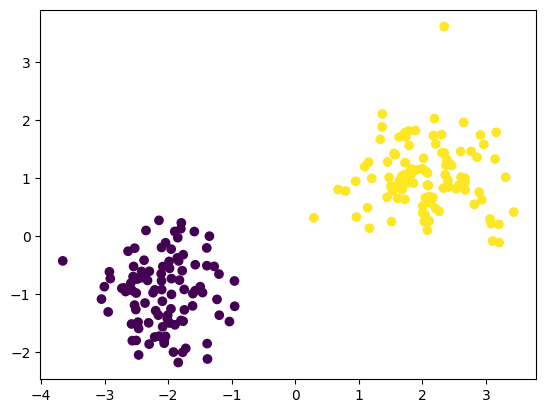

In [132]:
plt.scatter(x_data[:,0],x_data[:,1],c=y_classes)
plt.show()


The training data is linearisable.

In [133]:
from time import time

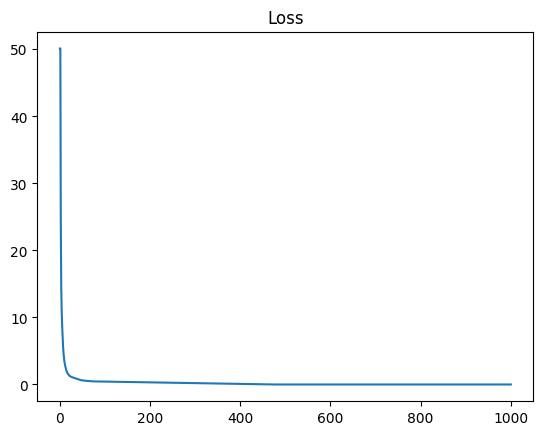

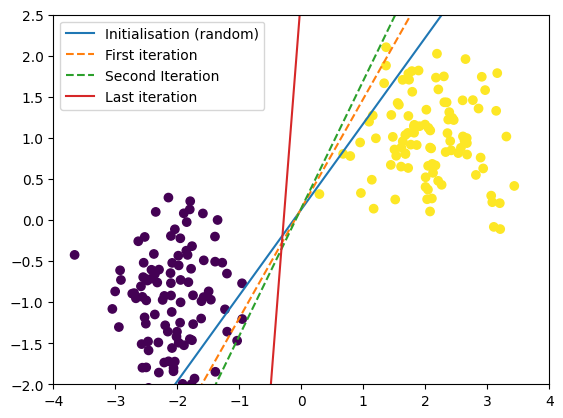

In [134]:
# Parameters
n_iter = 1000
lr = 0.001

def forward(x,w,b):
    return x@w + b

def hinge_loss(y,y_bar):
    l = 1-np.multiply(y,y_bar)
    l[l<0]=0
    return l.sum()

def gradient_loss(x,w,y,b):
    dw = -y.reshape(len(y),1)*x
    dw[np.multiply(y,forward(x,w,b))>=1]=0
    dw = dw.sum(axis=0)
    db = -y
    db[np.multiply(y,forward(x,w,b))>=1]=0
    db = db.sum()
    return dw,db

def numpy_class():
    w = np.random.randn(2)
    b = np.random.randn()
    ws=[w.copy()]
    bs=[b]
    losses=[hinge_loss(y_classes,forward(x_data,w,b))]
    tic = time()
    for i in range(n_iter):
        y_bar = forward(x_data,w,b)
        loss = hinge_loss(y_classes, y_bar)
        dw,db = gradient_loss(x_data,w,y_classes,b)
        w -= lr * dw
        b -= lr * db
        ws.append(w.copy())
        bs.append(b)
        losses.append(loss)
    toc=time()
    return ws,bs,losses,toc-tic

w_numpy,b_numpy,losses_numpy,t_numpy = numpy_class()
plt.plot(losses_numpy)
plt.title("Loss")
plt.show()

plt.scatter(x_data[:,0],x_data[:,1],c=y_classes)
t = np.linspace(-4,4,1000)

plt.plot(t,-w_numpy[0][0]/w_numpy[0][1] * t - b_numpy[0]/w_numpy[0][1],label = "Initialisation (random)",)
plt.plot(t,-w_numpy[1][0]/w_numpy[1][1] * t - b_numpy[1]/w_numpy[1][1],'--',label = "First iteration")
plt.plot(t,-w_numpy[2][0]/w_numpy[2][1] * t - b_numpy[2]/w_numpy[2][1],'--',label = "Second Iteration")
plt.plot(t,-w_numpy[-1][0]/w_numpy[-1][1] * t - b_numpy[-1]/w_numpy[-1][1],label = "Last iteration")
plt.legend()
plt.xlim([-4,4])
plt.ylim([-2,2.5])
plt.show()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further (optional)
> Try to replace the Hinge loss by the cross-entropy loss in your implementation

</div>

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Implement linear classification with JAX

> 1. Initialize weights and bias.
> 2. Define the loss function using the jax.nn.softmax_cross_entropy_with_logits function.
> 3. Implement gradient descent to optimize the weights and bias.

</div>

In [135]:
import optax

In [136]:
y_classes_jax = y_classes.copy()
y_classes_jax[y_classes_jax==-1]=0

In [137]:
def sigmoid(t):
    return 1 / (1 + jnp.exp(-t))

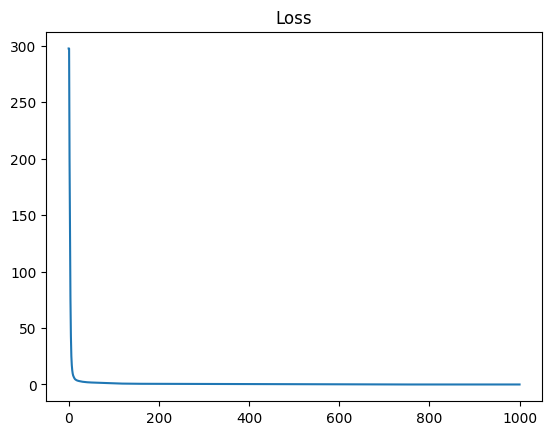

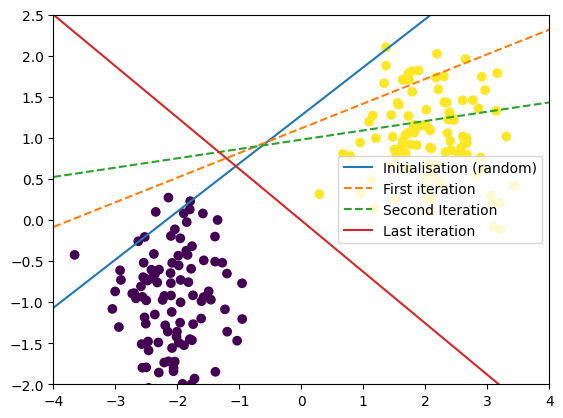

In [138]:
# Parameters
n_iter = 1000
lr = 0.001

def forward_sigmoid(x,w,b):
    return sigmoid(x@w + b)

def cross_entropy_loss(y,x,w,b):
    return optax.softmax_cross_entropy(forward(x,w,b),y)


grad_loss_function = jit(grad(cross_entropy_loss, argnums=[2, 3]))

def jax_class():
    k_0, k_1 = random.split(key, 2)
    w = random.normal(k_0, (2,))
    b = random.normal(k_1, (1,))

    ws=[w.copy()]
    bs=[b]
    losses=[cross_entropy_loss(y_classes_jax,x_data,w,b)]

    tic = time()
    for i in range(n_iter):
        y_bar = forward_sigmoid(x_data,w,b)
        loss = cross_entropy_loss(y_classes_jax,x_data,w,b)
        dw,db = grad_loss_function(y_classes_jax,x_data,w,b)
        w -= lr * dw
        b -= lr * db
        ws.append(w)
        bs.append(b)
        losses.append(loss)
    toc=time()
    return ws,bs,losses,toc-tic

w_jax,b_jax,losses_jax,t_jax = numpy_class()
plt.plot(losses_jax)
plt.title("Loss")
plt.show()

plt.scatter(x_data[:,0],x_data[:,1],c=y_classes_jax)
t = np.linspace(-4,4,1000)

plt.plot(t,-w_jax[0][0]/w_jax[0][1] * t - b_jax[0]/w_jax[0][1],label = "Initialisation (random)",)
plt.plot(t,-w_jax[1][0]/w_jax[1][1] * t - b_jax[1]/w_jax[1][1],'--',label = "First iteration")
plt.plot(t,-w_jax[2][0]/w_jax[2][1] * t - b_jax[2]/w_jax[2][1],'--',label = "Second Iteration")
plt.plot(t,-w_jax[-1][0]/w_jax[-1][1] * t - b_jax[-1]/w_jax[-1][1],label = "Last iteration")
plt.legend()
plt.xlim([-4,4])
plt.ylim([-2,2.5])
plt.show()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.3 - Compare the results of the NumPy and JAX implementations.
> 1. Plot the decision boundary for each implementation.
> 2. Compare the training time and accuracy of each implementation.

</div>

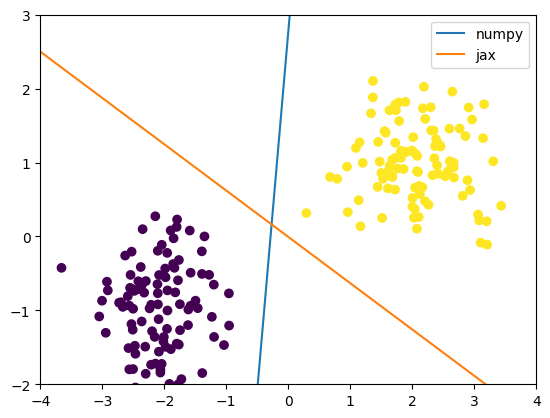

In [139]:
plt.scatter(x_data[:,0],x_data[:,1],c=y_classes)
plt.plot(t,-w_numpy[-1][0]/w_numpy[-1][1] * t - b_numpy[-1]/w_numpy[-1][1],label = "numpy")
plt.plot(t,-w_jax[-1][0]/w_jax[-1][1] * t - b_jax[-1]/w_jax[-1][1],label = "jax")
plt.legend()
plt.xlim([-4,4])
plt.ylim([-2,3])
plt.show()

In [140]:
y_numpy = forward(x_data,w_numpy[-1],b_numpy[-1])
y_jax = forward_sigmoid(x_data,w_jax[-1],b_jax[-1])

tester_numpy = np.multiply(y_numpy,y_classes) #Check if they have the same sign
tester_jax = (y_jax>0.5) == y_classes_jax #Use a 0.5 threshold to classify 

jax_accuracy = (tester_jax>0).sum() / len(x_data)
numpy_accuracy = (tester_numpy>0).sum() / len(x_data)

print(f"{t_numpy=}\n{t_jax=}\n{numpy_accuracy=}\n{jax_accuracy=}")

t_numpy=0.03805065155029297
t_jax=0.0407102108001709
numpy_accuracy=1.0
jax_accuracy=Array(1., dtype=float32)


<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further (optional)
> Implement a more complex dataset and compare the results of the NumPy and JAX implementations.

</div>

## Exercise 2 - Polynomial regression

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> In this exercise, you will implement polynomial regression using NumPy and JAX. This should be a quite straightforward extension of what we have seen until now. We deliberately removed details of the implementation (list of points to adress) so that you can start defining your first entire machine learning setup by yourself.

</div>

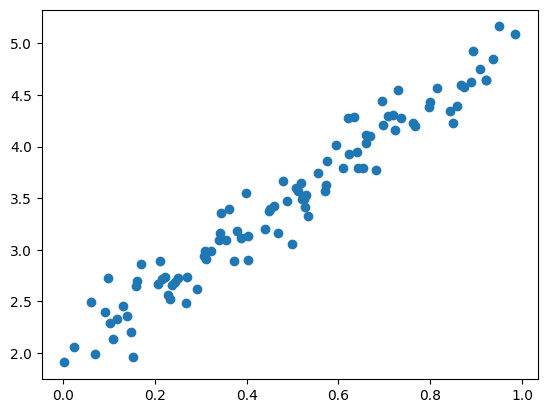

In [141]:
plt.scatter(x,y)

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.1 - Implement polynomial regression using NumPy with gradient descent.

</div>

In [142]:
X = x[:,np.newaxis]

Gradient Descent coefficients: [ 2.1622798   2.14552     0.9629192  -0.12486498]


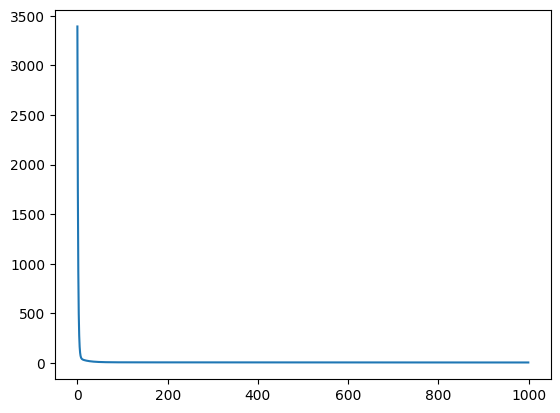

In [143]:
def forward_poly(x,w):
    return w@x.T

def mse_loss_poly(x,y,w):
    return ((y-w@x.T)**2).sum() 

def mse_loss_poly_gradient(x,y,w):
    gradients = np.zeros(len(w))
    for i in range(len(w)):
        gradients[i] = -2*(x[:,i]*(y-w@x.T)).sum() 
    return gradients

def polynomial_regression(key, X, y, n=3,lr=0.05, n_iter=1000):
    X_poly = np.concatenate([X**i for i in range(n+1)],axis=1)
    w = random.normal(key, (n+1,))
    loss_history = []
    for _ in range(n_iter):
        #y_bar = forward_poly(X_poly,w)
        loss = mse_loss_poly(X_poly, y, w)
        gradient = mse_loss_poly_gradient(X_poly, y, w)
        w -= lr * gradient
        loss_history.append(loss)
    return w, np.array(loss_history)

n=3
key_gd, key = random.split(key, 2)
w, loss_history = polynomial_regression(key_gd, X, y,n=n,lr=0.001)
print("Gradient Descent coefficients:", w)
plt.plot(loss_history)
plt.show()

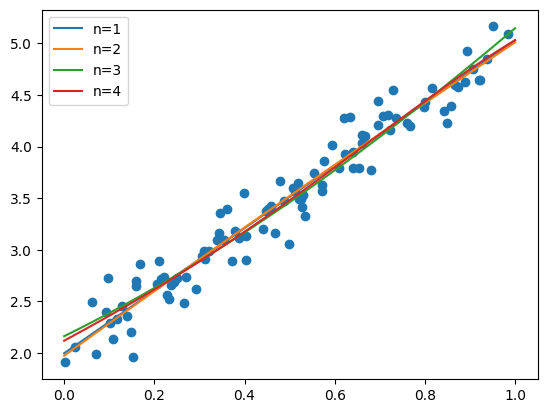

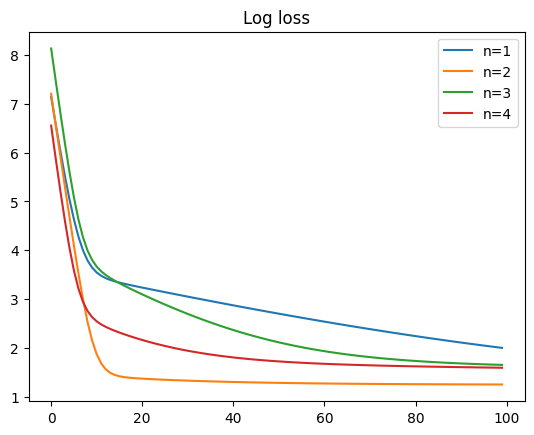

In [144]:
t = np.linspace(0,1,1000)

plt.scatter(x,y)
for n in range(1,5):
    t_poly = np.concatenate([t[:, np.newaxis]**i for i in range(n+1)],axis=1)
    w, loss_history = polynomial_regression(key_gd, X, y,n=n,lr=0.001)
    plt.figure(1)
    plt.plot(t,w@t_poly.T,label=f"{n=}")
    plt.legend()
    plt.figure(2)
    plt.plot(np.log(loss_history[:100]),label=f"{n=}")
    plt.legend()
    plt.title("Log loss")



<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.2. Implement polynomial regression using JAX with gradient descent.

</div>

Gradient Descent coefficients: [ 2.2609208   1.5811298   1.6830441  -0.32391152]


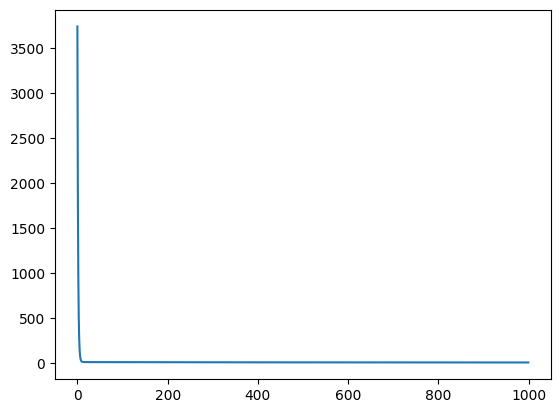

In [145]:

grad_loss_function_poly = jit(grad(mse_loss_poly,argnums=[2]))

def polynomial_regression_jax(key, X, y, n=3,lr=0.05, n_iter=1000):
    X_poly = np.concatenate([X**i for i in range(n+1)],axis=1)
    w = random.normal(key, (n+1,))
    loss_history = []
    for _ in range(n_iter):
        #y_bar = forward_poly(X_poly,w)
        loss = mse_loss_poly(X_poly, y, w)
        gradient = grad_loss_function_poly(X_poly, y, w)[0]
        w -= lr * gradient
        loss_history.append(loss)
    return w, np.array(loss_history)

n=3
key_gd, key = random.split(key, 2)
w_jax, loss_history_jax = polynomial_regression_jax(key_gd, X, y,n=n,lr=0.001)
print("Gradient Descent coefficients:", w_jax)
plt.plot(loss_history_jax)
plt.show()

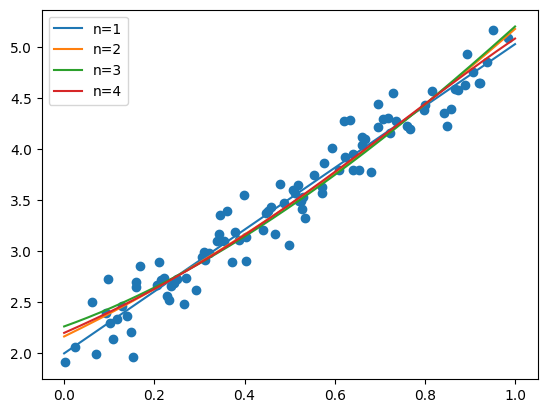

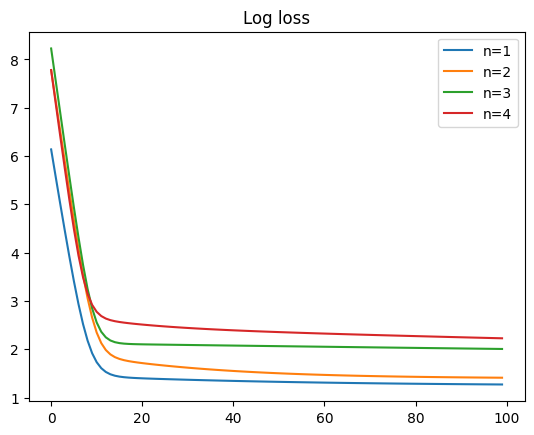

In [146]:
t = np.linspace(0,1,1000)

plt.scatter(x,y)
for n in range(1,5):
    t_poly = np.concatenate([t[:, np.newaxis]**i for i in range(n+1)],axis=1)
    w_jax, loss_history_jax = polynomial_regression_jax(key_gd, X, y,n=n,lr=0.001)
    plt.figure(1)
    plt.plot(t,w_jax@t_poly.T,label=f"{n=}")
    plt.legend()
    plt.figure(2)
    plt.plot(np.log(loss_history_jax[:100]),label=f"{n=}")
    plt.legend()
    plt.title("Log loss")



<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.3 - Compare the results of both implementations and the speed of the optimization algorithm.

</div>

In [147]:
n=2
key_gd, key = random.split(key, 2)
tic = time()
w_numpy, loss_history_numpy = polynomial_regression(key_gd, X, y,n=n,lr=0.001)
toc = time()
w_jax, loss_history_jax = polynomial_regression_jax(key_gd, X, y,n=n,lr=0.001)
toctoc = time()

print(f"numpy excecution time :{toc-tic}\njax excecution time :{toctoc-toc}\nnumpy final loss :{loss_history_numpy[-1]}\njax final loss :{loss_history_jax[-1]}")

numpy excecution time :0.7965669631958008
jax excecution time :0.15731072425842285
numpy final loss :4.46041202545166
jax final loss :4.460411071777344


Jax is faster. The two methods give similiar results

<a id="audio"></a>
# Audio applications

In order to test our algorithms on audio and music data, we will work with several datasets. We will both be using well-known state-of-art datasets (through the TF dataset system). But first, we will rely on a simple dataset (`Musclefish`) that should be downloaded on your local computer first from this [link](https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA)

**The following set of instructions will perform that automatically for you :)**

In [148]:
!curl https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA/download/musclefish.zip --output musclefish.zip
!unzip musclefish.zip
!mkdir data
!mv musclefish data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 11 3008k   11  336k    0     0  1434k      0  0:00:02 --:--:--  0:00:02 1435k
100 3008k  100 3008k    0     0  3309k      0 --:--:-- --:--:-- --:--:-- 3312k
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
Un sous-r�pertoire ou un fichier data existe d�j�.
'mv' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


## Dataset details

  |**Type**|*Origin*|
  |-------:|:---------|
  |**Classification**|[*MuscleFish*](http://knight.cis.temple.edu/~vasilis/Courses/CIS750/Papers/muscle_fish.pdf) dataset|
  |**Music-speech**|[*MIREX Recognition*](http://www.music-ir.org/mirex/wiki/2015:Music/Speech_Classification_and_Detection) set|
  |**Source separation**|[*SMC Mirum*](http://smc.inesctec.pt/research/data-2/) dataset|
  |**Speech recognition**|[*CMU Arctic*](http://festvox.org/cmu_arctic/) dataset|

**Unzip the file and place the `musclefish` folder inside a `data` folder in the root of this notebook**
For the first parts of the tutorial, we will mostly rely solely on the classification dataset. In order to facilitate the interactions, we provide a dataset class called `AudioSupervisedDataset` that will allow to import all audio datasets along the tutorials. This class also contains a set of holders and will allow us to perform batch-wise gradient descent.

```Python
class AudioSupervisedDataset():
    """
    Helper class to import datasets
    % class_path  : Path to the dataset (string)
    % type       : Type of dataset (string: 'classify', 'plain', 'metadata')
    """ 
    audio_files
    labels
    labels_names
    num_examples 
    num_classes 
```

We also provide a simplified function `import_dataset` that is demonstrated below.

***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**_Exercise_**  

  1. Launch the import procedure and check the corresponding structure
  2. Code a count function that prints the name and number of examples for each classes 

</div>

***

In [149]:
from cml.data import import_dataset, AudioSupervisedDataset
data_path = "data/"
batch_size = 16
# Instantiate the dataset class
train_dataset = import_dataset(data_path, "musclefish", 'train', batch_size=batch_size)
# Generate a batch of data from the train dataset
batch_x, batch_y = next(train_dataset)
# Print the shape of the input and output batch tensors
print(batch_x.shape)  # (16, 44100)
print(batch_y.shape)  # (16,)

Recursive search in data//musclefish


InvalidArgumentError: {{function_node __wrapped__ShuffleDatasetV3_device_/job:localhost/replica:0/task:0/device:CPU:0}} buffer_size must be greater than zero or UNKNOWN_CARDINALITY [Op:ShuffleDatasetV3] name: 

In [ ]:
#%% Q-0.1.2 - Count function to print the number of examples in each class along with class label

n_batch = 0
train_dataset._reset_generator()
for batch_x, batch_y in iter(train_dataset):
    n_batch += 1
    ######################
    # YOUR CODE GOES HERE
    ######################

print(n_batch)

52


### Preprocessing

We will rely on a set of spectral transforms that allow to obtain a more descriptive view over the audio information. As most of these are out of the scope of the machine learning course, we redirect you to a [signal processing course](https://ccrma.stanford.edu/~jos/sasp/) proposed by [Julius O. Smith](https://ccrma.stanford.edu/~jos/).  

The following functions to compute various types of transforms are given as part of the basic audio dataset class, in the `cml.data.audio` package

  |**Name**|*Transform*|
  |-------:|:----------|
  |`stft`       |[Short-term Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)|
  |`mel`  |[Mel scale](https://en.wikipedia.org/wiki/Mel_scale) transform|
  |`chroma` |[Chromas vector](https://en.wikipedia.org/wiki/Harmonic_pitch_class_profiles)|
  |`cqt`        |[Constant-Q](https://en.wikipedia.org/wiki/Constant_Q_transform) transform|

In order to perform the various computations, we provide the following function, in the `AudioSupervisedDataset` which performs the different transforms on a complete dataset.  

``` Python
dataset.transform(index, name)
    """ index   : Specific index in our dataset """
    """ name    : Name of the transform to apply """

# The name can be selected in 
"stft"      # Power spectrum (STFT)
"mel"       # Spectrum in Mel scale
"chroma"    # Chroma vectors
"cqt"       # Constant-Q transform
```


***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**Exercise**  

  1. Launch the transform computation procedure and check the corresponding structure
  2. For each class, select a random element and plot its various transforms on a single plot. You should obtain plots similar to those shown afterwards.
  3. For each transform, try to spot major pros and cons of their representation.
  
</div>

***

In [ ]:
# 0.2 - Pre-process the audio to obtain spectral transforms 
power_spec = train_dataset.transform(0, "stft")

In [ ]:
#%% Q-0.2.2 - Plot the various transforms 

######################
# YOUR CODE GOES HERE
######################


### Features

<div markdown = "1">

As you might have noted from the previous exercice, most spectral transforms have a very high dimensionality, and might not be suited to exhibit the relevant structure of different classes. To that end, we provide a set of functions for computing several spectral features in the `cml.data` package, we redirect interested readers to this [exhaustive article](http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf) on spectral features computation.

  |**File**|*Transform*|
  |-------:|:----------|
  |`spectral_centroid`|Spectral centroid|
  |`spectral_bandwidth`|Spectral bandwidth|
  |`spectral_contrast`|Spectral contrast|
  |`spectral_flatness`|Spectral flatness|
  |`spectral_rolloff`|Spectral rolloff|

Once again, we provide a function to perform the computation of different features on a complete set. Note that for each feature, we obtain the temporal evolution in a vector. Therefore, for further learning tasks, if you wish to obtain simplified spaces, you might need to compute the mean and standard deviation of each feature.

``` Python
dataset.feature(index, name)
    """ index   : Specific index in our dataset """
    """ name    : Name of the feature to obtain """

# Name can be chosen inside the following
"loudness"    # Loudness
"centroid"    # Spectral centroid
"bandwidth"   # Spectral bandwidth
"contrast"    # Spectral contrast
"flatness"    # Spectral flatness
"rolloff"     # Spectral rolloff

```

***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**Exercise**

  1. Launch the feature computation procedure and check the corresponding structure
  2. This time for each class, superimpose the plots of various features on a single plot, along with a boxplot of mean and standard deviations. You should obtain plots similar to those shown afterwards.
  3. What conclusions can you make on the discriminative power of each feature ?
  4. Perform scatter plots of the mean features for all the dataset, while coloring different classes.
  5. What conclusions can you make on the discriminative power of mean features ?

</div>

***

In [ ]:
# 0.3 - Compute temporal spectral features
power_spec = train_dataset.feature(0, "centroid")

In [ ]:
#%% Q-0.3.2 - Plot the various features 

# Use these styles for boxplot
boxprops=dict(linewidth=3, color='white')
whiskerprops=dict(linewidth=3, color='white')
medianprops=dict(linewidth=2.5, color='firebrick')
flierprops = dict(markeredgecolor='white', markerfacecolor='firebrick')

######################
# YOUR CODE GOES HERE
######################


In [ ]:
#%% Q-0.3.4 - Observe the distribution of classes for different features

# This allows to use 3D rendering in matplotlib
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(12,8))
# Create a vector of random colors for each class
colorVect = np.zeros((3, len(data_struct["class_names"])));
for c in range(len(data_struct["class_names"])):
    colorVect[:,c] = np.random.rand(3);

######################
# YOUR CODE GOES HERE
######################


That's it for this tutorial, now remember that we can use any form of description (features) as a basis for learning algorithms. We will see in the next tutorial what we an do with these features.